<a href="https://colab.research.google.com/github/guidiandrea/Metapath2Vec_On_MovieLens1M/blob/main/Graph_Representation_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
!pip install umap-learn

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 3.0 MB 7.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.6 MB 7.3 MB/s 
     |████████████████████████████████| 222 kB 7.9 MB/s 
     |████████████████████████████████| 376 kB 44.7 MB/s 
     |████████████████████████████████| 45 kB 4.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388143 sha256=fcdc7e923834943a36378964fb2c508e274ab2a344ecb854bb555944f15bc96d
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric
     |████████████████████████████████| 80 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 15.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=9a39230b4f24365770d5ab3dccde88e88b977135c40784f

In [3]:
import pandas as pd
import networkx as nx 
import torch_geometric
import torch
import random
import numpy as np 
import os 
from umap import UMAP 

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-08-21 12:34:28--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  11.2MB/s    in 0.5s    

2021-08-21 12:34:29 (11.2 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [5]:
os.listdir('ml-1m/')

['movies.dat', 'README', 'users.dat', 'ratings.dat']

In [6]:
users = pd.read_csv("ml-1m/users.dat", sep='::',header=None, names=['user_id','gender','age','occupation','zip-code'])
users

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [7]:
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', header=None, names=['user_id','item_id','rating','timestamp'])
ratings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [8]:
items = pd.read_csv("ml-1m/movies.dat",sep='::', header=None, names=['movie_id','movie_title','genres'])
items

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,movie_id,movie_title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [9]:
items['genre_list']=items.genres.str.split('|')
items['genre_list']

0        [Animation, Children's, Comedy]
1       [Adventure, Children's, Fantasy]
2                      [Comedy, Romance]
3                        [Comedy, Drama]
4                               [Comedy]
                      ...               
3878                            [Comedy]
3879                             [Drama]
3880                             [Drama]
3881                             [Drama]
3882                   [Drama, Thriller]
Name: genre_list, Length: 3883, dtype: object

In [10]:
genres = ["Action" , "Adventure" , "Animation" ,
  "Children's" , "Comedy" , "Crime" , "Documentary" , "Drama" , "Fantasy" ,
  "Film-Noir" , "Horror" , "Musical" , "Mystery" , "Romance" , "Sci-Fi" ,
  "Thriller" , "War" , "Western"]

genres_to_idx = {k:i for i,k in enumerate(genres)}

def return_genre_idx(x):
    
    return [genres_to_idx[elem] for elem in x]

items['genre_list_idx']=items['genre_list'].apply(return_genre_idx)
items['genre_list_idx']

0       [2, 3, 4]
1       [1, 3, 8]
2         [4, 13]
3          [4, 7]
4             [4]
          ...    
3878          [4]
3879          [7]
3880          [7]
3881          [7]
3882      [7, 15]
Name: genre_list_idx, Length: 3883, dtype: object

In [11]:
full_table = ratings.merge(items, left_on='item_id',right_on='movie_id')
full_table


,user_id,item_id,rating,timestamp,movie_id,movie_title,genres,genre_list,genre_list_idx
0,1,1193,5,978300760,1193,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama],[7]
1,2,1193,5,978298413,1193,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama],[7]
2,12,1193,4,978220179,1193,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama],[7]
3,15,1193,4,978199279,1193,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama],[7]
4,17,1193,5,978158471,1193,One Flew Over the Cuckoo's Nest (1975),Drama,[Drama],[7]
...,...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,2198,Modulations (1998),Documentary,[Documentary],[6]
1000205,5675,2703,3,976029116,2703,Broken Vessels (1998),Drama,[Drama],[7]
1000206,5780,2845,1,958153068,2845,White Boys (1999),Drama,[Drama],[7]
1000207,5851,3607,5,957756608,3607,One Little Indian (1973),Comedy|Drama|Western,"[Comedy, Drama, Western]","[4, 7, 17]"


In [12]:
edge_index_dict = {}
edge_index_dict[("user_id","has_liked","item_id")] = torch.Tensor(\
    [full_table['user_id'].astype(int).tolist(),
    full_table['item_id'].astype(int).tolist()]).long()


In [13]:
movies_nodes_list = []
genres_nodes_list = []
for index,row in items.iterrows():
    for mov in row['genre_list_idx']:
        
        movies_nodes_list.append(row['movie_id'])
        genres_nodes_list.append(mov)

edge_index_dict[("item_id","has_genres","genre")]= \
            torch.Tensor([movies_nodes_list,genres_nodes_list]).long()
edge_index_dict[("genre","belongs_to","item_id")]= \
                torch.Tensor([genres_nodes_list,movies_nodes_list]).long()
edge_index_dict[("item_id","liked_by","user_id")] = torch.Tensor(\
    [full_table['item_id'].astype(int).tolist(),full_table['user_id'].astype(int).tolist(),
    ]).long()



In [24]:
from torch_geometric.nn import MetaPath2Vec
from itertools import product

metapath=[('user_id',
  'has_liked',
  'item_id'),
('item_id',
  'has_genres',
  'genre'),
('genre',
  'belongs_to',
  'item_id'),
     ('item_id',
  'liked_by',
  'user_id')    ]

embedding_dims = [2**(x) for x in range(5,9)]
walk_length=[10*x for x in range(5,11)]
context_size = [8,16,24,48]
combinations = list(product(embedding_dims,walk_length,context_size))
n_comb = len(combinations)
i=1
models_dict = {}
models_dict["metapath"] = metapath
for tup in combinations:

    models_dict[tup] = {}
    print(f"Trying combination {i} out of {n_comb}")
    print(f"Params of comb {i}: {tup}")
    model = MetaPath2Vec(edge_index_dict=edge_index_dict, embedding_dim=tup[0],metapath=metapath,walk_length=tup[1], context_size=tup[2],
                     walks_per_node=1, num_negative_samples=5,
                     sparse=True).to('cuda')
    loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.025)
    epoch_loss = []
    for epoch in range(1, 11):
        train(model,epoch)
        print(f"epoch: {epoch}, loss: {loss}")
        epoch_loss.append(loss)
    models_dict[tup]["epoch_loss"] = epoch_loss
    models_dict[tup]["trained_model"] = model
    i=i+1



    


Trying combination 1 out of 96
Params of comb 1: (32, 50, 8)


48it [00:00, 78.01it/s]

epoch: 1, loss: 1.894911527633667



48it [00:00, 84.61it/s]

epoch: 2, loss: 1.3234699964523315



48it [00:00, 88.67it/s] 

epoch: 3, loss: 1.2582563161849976



48it [00:00, 91.28it/s] 

epoch: 4, loss: 1.2211309671401978



48it [00:00, 88.54it/s]

epoch: 5, loss: 1.1967602968215942



48it [00:00, 90.25it/s] 

epoch: 6, loss: 1.2081044912338257



48it [00:00, 85.33it/s]

epoch: 7, loss: 1.1936445236206055



48it [00:00, 86.54it/s]

epoch: 8, loss: 1.199015736579895



48it [00:00, 87.31it/s]

epoch: 9, loss: 1.204063892364502



48it [00:00, 85.65it/s]


epoch: 10, loss: 1.195136547088623
Trying combination 2 out of 96
Params of comb 2: (32, 50, 16)


48it [00:00, 70.06it/s]

epoch: 1, loss: 1.8190462589263916



48it [00:00, 72.16it/s]

epoch: 2, loss: 1.3214792013168335



48it [00:00, 74.16it/s]

epoch: 3, loss: 1.2421612739562988



48it [00:00, 67.21it/s]

epoch: 4, loss: 1.2366788387298584



48it [00:00, 72.16it/s]

epoch: 5, loss: 1.2319591045379639



48it [00:00, 70.08it/s]

epoch: 6, loss: 1.2302509546279907



48it [00:00, 72.47it/s]

epoch: 7, loss: 1.2323371171951294



48it [00:00, 72.34it/s]

epoch: 8, loss: 1.2027965784072876



48it [00:00, 71.13it/s]

epoch: 9, loss: 1.2130156755447388



48it [00:00, 72.36it/s]


epoch: 10, loss: 1.2134196758270264
Trying combination 3 out of 96
Params of comb 3: (32, 50, 24)


48it [00:00, 65.45it/s]

epoch: 1, loss: 1.7618283033370972



48it [00:00, 67.46it/s]

epoch: 2, loss: 1.3325839042663574



48it [00:00, 65.91it/s]

epoch: 3, loss: 1.2748708724975586



48it [00:00, 65.29it/s]

epoch: 4, loss: 1.2417144775390625



48it [00:00, 65.86it/s]

epoch: 5, loss: 1.255298376083374



48it [00:00, 67.34it/s]

epoch: 6, loss: 1.2218897342681885



48it [00:00, 68.45it/s]

epoch: 7, loss: 1.245222568511963



48it [00:00, 66.21it/s]

epoch: 8, loss: 1.2014504671096802



48it [00:00, 64.63it/s]

epoch: 9, loss: 1.2387923002243042



48it [00:00, 61.39it/s]


epoch: 10, loss: 1.2085387706756592
Trying combination 4 out of 96
Params of comb 4: (32, 50, 48)


48it [00:00, 111.76it/s]

epoch: 1, loss: 2.3248229026794434



48it [00:00, 108.94it/s]

epoch: 2, loss: 1.6088227033615112



48it [00:00, 108.20it/s]

epoch: 3, loss: 1.4340102672576904



48it [00:00, 109.57it/s]

epoch: 4, loss: 1.3582918643951416



48it [00:00, 111.76it/s]

epoch: 5, loss: 1.3285701274871826



48it [00:00, 107.65it/s]

epoch: 6, loss: 1.3136231899261475



48it [00:00, 108.55it/s]

epoch: 7, loss: 1.2673355340957642



48it [00:00, 109.73it/s]

epoch: 8, loss: 1.2644524574279785



48it [00:00, 111.54it/s]

epoch: 9, loss: 1.2782397270202637



48it [00:00, 111.16it/s]


epoch: 10, loss: 1.2973610162734985
Trying combination 5 out of 96
Params of comb 5: (32, 60, 8)


48it [00:00, 78.73it/s]

epoch: 1, loss: 1.8456370830535889



48it [00:00, 75.54it/s]

epoch: 2, loss: 1.3397120237350464



48it [00:00, 74.11it/s]

epoch: 3, loss: 1.2586252689361572



48it [00:00, 78.11it/s]

epoch: 4, loss: 1.2157220840454102



48it [00:00, 75.88it/s]

epoch: 5, loss: 1.2195134162902832



48it [00:00, 77.01it/s]

epoch: 6, loss: 1.1885782480239868



48it [00:00, 76.73it/s]

epoch: 7, loss: 1.1969552040100098



48it [00:00, 77.20it/s]

epoch: 8, loss: 1.1748836040496826



48it [00:00, 74.65it/s]

epoch: 9, loss: 1.1942379474639893



48it [00:00, 79.67it/s]


epoch: 10, loss: 1.174209713935852
Trying combination 6 out of 96
Params of comb 6: (32, 60, 16)


48it [00:00, 61.47it/s]

epoch: 1, loss: 1.7242180109024048



48it [00:00, 61.60it/s]

epoch: 2, loss: 1.3026485443115234



48it [00:00, 60.15it/s]

epoch: 3, loss: 1.2515795230865479



48it [00:00, 59.93it/s]

epoch: 4, loss: 1.2326598167419434



48it [00:00, 61.88it/s]

epoch: 5, loss: 1.2328094244003296



48it [00:00, 59.07it/s]

epoch: 6, loss: 1.2121174335479736



48it [00:00, 61.89it/s]

epoch: 7, loss: 1.2114816904067993



48it [00:00, 61.36it/s]

epoch: 8, loss: 1.2246417999267578



48it [00:00, 62.36it/s]

epoch: 9, loss: 1.2005577087402344



48it [00:00, 62.27it/s]


epoch: 10, loss: 1.1972935199737549
Trying combination 7 out of 96
Params of comb 7: (32, 60, 24)


48it [00:00, 53.61it/s]

epoch: 1, loss: 1.6570067405700684



48it [00:00, 52.78it/s]

epoch: 2, loss: 1.3113534450531006



48it [00:00, 52.00it/s]

epoch: 3, loss: 1.2544822692871094



48it [00:00, 52.34it/s]

epoch: 4, loss: 1.2393707036972046



48it [00:00, 51.78it/s]

epoch: 5, loss: 1.2260538339614868



48it [00:00, 51.41it/s]

epoch: 6, loss: 1.2107056379318237



48it [00:00, 53.72it/s]

epoch: 7, loss: 1.2227895259857178



48it [00:00, 52.78it/s]

epoch: 8, loss: 1.2015355825424194



48it [00:00, 53.04it/s]

epoch: 9, loss: 1.2159335613250732



48it [00:00, 53.68it/s]


epoch: 10, loss: 1.205772876739502
Trying combination 8 out of 96
Params of comb 8: (32, 60, 48)


48it [00:00, 65.16it/s]

epoch: 1, loss: 1.8181676864624023



48it [00:00, 63.94it/s]

epoch: 2, loss: 1.3452070951461792



48it [00:00, 64.03it/s]

epoch: 3, loss: 1.2598888874053955



48it [00:00, 64.35it/s]

epoch: 4, loss: 1.2594884634017944



48it [00:00, 64.82it/s]

epoch: 5, loss: 1.2251837253570557



48it [00:00, 62.26it/s]

epoch: 6, loss: 1.235534906387329



48it [00:00, 63.23it/s]

epoch: 7, loss: 1.217132806777954



48it [00:00, 63.23it/s]

epoch: 8, loss: 1.2431098222732544



48it [00:00, 63.35it/s]

epoch: 9, loss: 1.2168561220169067



48it [00:00, 63.22it/s]


epoch: 10, loss: 1.2240123748779297
Trying combination 9 out of 96
Params of comb 9: (32, 70, 8)


48it [00:00, 67.50it/s]

epoch: 1, loss: 1.7758212089538574



48it [00:00, 69.83it/s]

epoch: 2, loss: 1.323163628578186



48it [00:00, 68.08it/s]

epoch: 3, loss: 1.236088514328003



48it [00:00, 69.51it/s]

epoch: 4, loss: 1.2145341634750366



48it [00:00, 69.86it/s]

epoch: 5, loss: 1.201019525527954



48it [00:00, 68.14it/s]

epoch: 6, loss: 1.1889888048171997



48it [00:00, 69.52it/s]

epoch: 7, loss: 1.1814934015274048



48it [00:00, 70.65it/s]

epoch: 8, loss: 1.1842221021652222



48it [00:00, 68.34it/s]

epoch: 9, loss: 1.1748883724212646



48it [00:00, 70.84it/s]


epoch: 10, loss: 1.1911143064498901
Trying combination 10 out of 96
Params of comb 10: (32, 70, 16)


48it [00:00, 53.87it/s]

epoch: 1, loss: 1.6262965202331543



48it [00:00, 53.30it/s]

epoch: 2, loss: 1.2822293043136597



48it [00:00, 53.09it/s]

epoch: 3, loss: 1.2316594123840332



48it [00:00, 53.94it/s]

epoch: 4, loss: 1.2422255277633667



48it [00:00, 52.71it/s]

epoch: 5, loss: 1.2177647352218628



48it [00:00, 53.60it/s]

epoch: 6, loss: 1.2156058549880981



48it [00:00, 51.05it/s]

epoch: 7, loss: 1.2140088081359863



48it [00:00, 53.06it/s]

epoch: 8, loss: 1.2146283388137817



48it [00:00, 52.55it/s]

epoch: 9, loss: 1.1960904598236084



48it [00:00, 50.98it/s]


epoch: 10, loss: 1.215178370475769
Trying combination 11 out of 96
Params of comb 11: (32, 70, 24)


48it [00:01, 43.21it/s]

epoch: 1, loss: 1.6713051795959473



48it [00:01, 42.88it/s]

epoch: 2, loss: 1.2764549255371094



48it [00:01, 44.63it/s]

epoch: 3, loss: 1.2433558702468872



48it [00:01, 43.72it/s]

epoch: 4, loss: 1.2303667068481445



48it [00:01, 43.93it/s]

epoch: 5, loss: 1.234867811203003



48it [00:01, 44.88it/s]

epoch: 6, loss: 1.2102644443511963



48it [00:01, 44.13it/s]

epoch: 7, loss: 1.209275722503662



48it [00:01, 43.62it/s]

epoch: 8, loss: 1.2237904071807861



48it [00:01, 44.38it/s]

epoch: 9, loss: 1.2139675617218018



48it [00:01, 43.99it/s]


epoch: 10, loss: 1.203092098236084
Trying combination 12 out of 96
Params of comb 12: (32, 70, 48)


48it [00:01, 44.17it/s]

epoch: 1, loss: 1.6578490734100342



48it [00:01, 43.71it/s]

epoch: 2, loss: 1.289759874343872



48it [00:01, 43.01it/s]

epoch: 3, loss: 1.2573806047439575



48it [00:01, 44.01it/s]

epoch: 4, loss: 1.2203443050384521



48it [00:01, 42.67it/s]

epoch: 5, loss: 1.2212045192718506



48it [00:01, 42.60it/s]

epoch: 6, loss: 1.2325650453567505



48it [00:01, 42.90it/s]

epoch: 7, loss: 1.222747802734375



48it [00:01, 43.99it/s]

epoch: 8, loss: 1.211104393005371



48it [00:01, 42.46it/s]

epoch: 9, loss: 1.2261229753494263



48it [00:01, 43.24it/s]


epoch: 10, loss: 1.2324846982955933
Trying combination 13 out of 96
Params of comb 13: (32, 80, 8)


48it [00:00, 63.86it/s]

epoch: 1, loss: 1.7110021114349365



48it [00:00, 59.82it/s]

epoch: 2, loss: 1.3066179752349854



48it [00:00, 60.87it/s]

epoch: 3, loss: 1.2230092287063599



48it [00:00, 61.22it/s]

epoch: 4, loss: 1.2273671627044678



48it [00:00, 61.73it/s]

epoch: 5, loss: 1.1876742839813232



48it [00:00, 58.52it/s]

epoch: 6, loss: 1.1793307065963745



48it [00:00, 60.39it/s]

epoch: 7, loss: 1.179314374923706



48it [00:00, 61.83it/s]

epoch: 8, loss: 1.166286587715149



48it [00:00, 62.04it/s]

epoch: 9, loss: 1.1769397258758545



48it [00:00, 62.50it/s]


epoch: 10, loss: 1.1729152202606201
Trying combination 14 out of 96
Params of comb 14: (32, 80, 16)


48it [00:01, 46.93it/s]

epoch: 1, loss: 1.622880458831787



48it [00:01, 45.70it/s]

epoch: 2, loss: 1.2773678302764893



48it [00:01, 46.12it/s]

epoch: 3, loss: 1.2282620668411255



48it [00:01, 45.17it/s]

epoch: 4, loss: 1.2205352783203125



48it [00:01, 46.47it/s]

epoch: 5, loss: 1.2171154022216797



48it [00:01, 46.51it/s]

epoch: 6, loss: 1.2054481506347656



48it [00:01, 46.40it/s]

epoch: 7, loss: 1.2086172103881836



48it [00:01, 46.13it/s]

epoch: 8, loss: 1.2021234035491943



48it [00:01, 45.48it/s]

epoch: 9, loss: 1.219592809677124



48it [00:01, 47.07it/s]


epoch: 10, loss: 1.1972472667694092
Trying combination 15 out of 96
Params of comb 15: (32, 80, 24)


48it [00:01, 38.22it/s]

epoch: 1, loss: 1.6158976554870605



48it [00:01, 36.71it/s]

epoch: 2, loss: 1.2738494873046875



48it [00:01, 36.35it/s]

epoch: 3, loss: 1.245595097541809



48it [00:01, 37.47it/s]

epoch: 4, loss: 1.220225214958191



48it [00:01, 36.77it/s]

epoch: 5, loss: 1.2150003910064697



48it [00:01, 37.70it/s]

epoch: 6, loss: 1.221958041191101



48it [00:01, 37.71it/s]

epoch: 7, loss: 1.199438452720642



48it [00:01, 37.92it/s]

epoch: 8, loss: 1.2253953218460083



48it [00:01, 36.47it/s]

epoch: 9, loss: 1.1946715116500854



48it [00:01, 37.01it/s]


epoch: 10, loss: 1.213348627090454
Trying combination 16 out of 96
Params of comb 16: (32, 80, 48)


48it [00:01, 32.60it/s]

epoch: 1, loss: 1.5957932472229004



48it [00:01, 32.97it/s]

epoch: 2, loss: 1.2729308605194092



48it [00:01, 32.09it/s]

epoch: 3, loss: 1.2330816984176636



48it [00:01, 32.68it/s]

epoch: 4, loss: 1.2354586124420166



48it [00:01, 32.26it/s]

epoch: 5, loss: 1.2308809757232666



48it [00:01, 32.37it/s]

epoch: 6, loss: 1.2060909271240234



48it [00:01, 32.57it/s]

epoch: 7, loss: 1.205758810043335



48it [00:01, 32.28it/s]

epoch: 8, loss: 1.2235050201416016



48it [00:01, 32.38it/s]

epoch: 9, loss: 1.2164411544799805



48it [00:01, 33.22it/s]


epoch: 10, loss: 1.2172582149505615
Trying combination 17 out of 96
Params of comb 17: (32, 90, 8)


48it [00:00, 57.06it/s]

epoch: 1, loss: 1.6879056692123413



48it [00:00, 56.64it/s]

epoch: 2, loss: 1.3007135391235352



48it [00:00, 56.59it/s]

epoch: 3, loss: 1.2264885902404785



48it [00:00, 56.35it/s]

epoch: 4, loss: 1.2004613876342773



48it [00:00, 56.06it/s]

epoch: 5, loss: 1.1921296119689941



48it [00:00, 56.47it/s]

epoch: 6, loss: 1.202635407447815



48it [00:00, 56.14it/s]

epoch: 7, loss: 1.1710920333862305



48it [00:00, 55.27it/s]

epoch: 8, loss: 1.1786859035491943



48it [00:00, 55.23it/s]

epoch: 9, loss: 1.1759097576141357



48it [00:00, 56.77it/s]


epoch: 10, loss: 1.1680793762207031
Trying combination 18 out of 96
Params of comb 18: (32, 90, 16)


48it [00:01, 40.91it/s]

epoch: 1, loss: 1.5980923175811768



48it [00:01, 41.08it/s]

epoch: 2, loss: 1.2925353050231934



48it [00:01, 41.17it/s]

epoch: 3, loss: 1.2277814149856567



48it [00:01, 41.33it/s]


epoch: 4, loss: 1.2137696743011475


48it [00:01, 40.08it/s]

epoch: 5, loss: 1.2073287963867188



48it [00:01, 39.54it/s]

epoch: 6, loss: 1.205207347869873



48it [00:01, 40.91it/s]

epoch: 7, loss: 1.2104490995407104



48it [00:01, 40.08it/s]

epoch: 8, loss: 1.188597559928894



48it [00:01, 40.48it/s]

epoch: 9, loss: 1.197906732559204



48it [00:01, 39.36it/s]


epoch: 10, loss: 1.2080020904541016
Trying combination 19 out of 96
Params of comb 19: (32, 90, 24)


48it [00:01, 32.69it/s]

epoch: 1, loss: 1.5877375602722168



48it [00:01, 32.02it/s]

epoch: 2, loss: 1.292726993560791



48it [00:01, 32.70it/s]

epoch: 3, loss: 1.2342619895935059



48it [00:01, 32.09it/s]

epoch: 4, loss: 1.2213352918624878



48it [00:01, 32.54it/s]

epoch: 5, loss: 1.2408366203308105



48it [00:01, 32.67it/s]

epoch: 6, loss: 1.229317545890808



48it [00:01, 32.23it/s]

epoch: 7, loss: 1.2154769897460938



48it [00:01, 32.29it/s]

epoch: 8, loss: 1.2078830003738403



48it [00:01, 32.47it/s]

epoch: 9, loss: 1.2044057846069336



48it [00:01, 32.79it/s]


epoch: 10, loss: 1.2048370838165283
Trying combination 20 out of 96
Params of comb 20: (32, 90, 48)


48it [00:01, 25.08it/s]

epoch: 1, loss: 1.5632786750793457



48it [00:01, 25.51it/s]

epoch: 2, loss: 1.265515685081482



48it [00:01, 25.93it/s]

epoch: 3, loss: 1.2508862018585205



48it [00:01, 25.10it/s]

epoch: 4, loss: 1.2269686460494995



48it [00:01, 25.67it/s]

epoch: 5, loss: 1.2067886590957642



48it [00:01, 25.81it/s]

epoch: 6, loss: 1.2023626565933228



48it [00:01, 25.16it/s]

epoch: 7, loss: 1.2276413440704346



48it [00:01, 25.71it/s]

epoch: 8, loss: 1.2059763669967651



48it [00:01, 25.67it/s]

epoch: 9, loss: 1.2241699695587158



48it [00:01, 25.60it/s]


epoch: 10, loss: 1.2081942558288574
Trying combination 21 out of 96
Params of comb 21: (32, 100, 8)


48it [00:00, 51.76it/s]

epoch: 1, loss: 1.6391812562942505



48it [00:00, 51.90it/s]

epoch: 2, loss: 1.2780303955078125



48it [00:00, 49.98it/s]

epoch: 3, loss: 1.2183095216751099



48it [00:00, 51.07it/s]

epoch: 4, loss: 1.197878360748291



48it [00:00, 52.46it/s]

epoch: 5, loss: 1.2102411985397339



48it [00:00, 52.89it/s]

epoch: 6, loss: 1.172168254852295



48it [00:00, 52.48it/s]

epoch: 7, loss: 1.1660680770874023



48it [00:00, 50.47it/s]

epoch: 8, loss: 1.1900286674499512



48it [00:00, 51.78it/s]

epoch: 9, loss: 1.170346975326538



48it [00:00, 51.95it/s]


epoch: 10, loss: 1.1555694341659546
Trying combination 22 out of 96
Params of comb 22: (32, 100, 16)


48it [00:01, 36.87it/s]

epoch: 1, loss: 1.5559372901916504



48it [00:01, 36.78it/s]

epoch: 2, loss: 1.2565622329711914



48it [00:01, 35.11it/s]

epoch: 3, loss: 1.2220731973648071



48it [00:01, 35.60it/s]

epoch: 4, loss: 1.2186834812164307



48it [00:01, 36.36it/s]

epoch: 5, loss: 1.2025487422943115



48it [00:01, 36.37it/s]

epoch: 6, loss: 1.195924162864685



48it [00:01, 37.11it/s]

epoch: 7, loss: 1.1941006183624268



48it [00:01, 37.30it/s]

epoch: 8, loss: 1.2067689895629883



48it [00:01, 36.57it/s]

epoch: 9, loss: 1.1937081813812256



48it [00:01, 35.46it/s]


epoch: 10, loss: 1.2067162990570068
Trying combination 23 out of 96
Params of comb 23: (32, 100, 24)


48it [00:01, 28.72it/s]

epoch: 1, loss: 1.5317662954330444



48it [00:01, 28.25it/s]

epoch: 2, loss: 1.2512331008911133



48it [00:01, 28.25it/s]

epoch: 3, loss: 1.2224352359771729



48it [00:01, 28.85it/s]

epoch: 4, loss: 1.2291769981384277



48it [00:01, 28.39it/s]

epoch: 5, loss: 1.1961162090301514



48it [00:01, 28.56it/s]

epoch: 6, loss: 1.2128033638000488



48it [00:01, 28.18it/s]

epoch: 7, loss: 1.2002204656600952



48it [00:01, 28.84it/s]

epoch: 8, loss: 1.2059627771377563



48it [00:01, 28.53it/s]

epoch: 9, loss: 1.1951861381530762



48it [00:01, 27.67it/s]


epoch: 10, loss: 1.2113306522369385
Trying combination 24 out of 96
Params of comb 24: (32, 100, 48)


48it [00:02, 22.13it/s]

epoch: 1, loss: 1.512784719467163



48it [00:02, 21.88it/s]

epoch: 2, loss: 1.261804223060608



48it [00:02, 22.45it/s]

epoch: 3, loss: 1.229649543762207



48it [00:02, 22.00it/s]

epoch: 4, loss: 1.2436052560806274



48it [00:02, 21.65it/s]

epoch: 5, loss: 1.2014670372009277



48it [00:02, 21.56it/s]

epoch: 6, loss: 1.1946866512298584



48it [00:02, 22.35it/s]

epoch: 7, loss: 1.2192237377166748



48it [00:02, 22.08it/s]

epoch: 8, loss: 1.2067129611968994



48it [00:02, 21.67it/s]

epoch: 9, loss: 1.2045279741287231



48it [00:02, 21.81it/s]


epoch: 10, loss: 1.2148226499557495
Trying combination 25 out of 96
Params of comb 25: (64, 50, 8)


48it [00:00, 70.02it/s]

epoch: 1, loss: 2.614025592803955



48it [00:00, 69.97it/s]

epoch: 2, loss: 1.6123814582824707



48it [00:00, 70.61it/s]

epoch: 3, loss: 1.374302864074707



48it [00:00, 70.43it/s]

epoch: 4, loss: 1.3039511442184448



48it [00:00, 70.67it/s]

epoch: 5, loss: 1.23080313205719



48it [00:00, 69.93it/s]

epoch: 6, loss: 1.2139101028442383



48it [00:00, 71.94it/s]

epoch: 7, loss: 1.2123677730560303



48it [00:00, 69.30it/s]

epoch: 8, loss: 1.199623465538025



48it [00:00, 70.52it/s]

epoch: 9, loss: 1.1990818977355957



48it [00:00, 71.87it/s]


epoch: 10, loss: 1.2060781717300415
Trying combination 26 out of 96
Params of comb 26: (64, 50, 16)


48it [00:00, 50.19it/s]

epoch: 1, loss: 2.4094884395599365



48it [00:00, 48.84it/s]

epoch: 2, loss: 1.5194904804229736



48it [00:00, 49.82it/s]

epoch: 3, loss: 1.297484278678894



48it [00:00, 49.89it/s]

epoch: 4, loss: 1.2709752321243286



48it [00:00, 50.28it/s]

epoch: 5, loss: 1.2405776977539062



48it [00:00, 49.54it/s]

epoch: 6, loss: 1.2526154518127441



48it [00:00, 50.08it/s]

epoch: 7, loss: 1.2040871381759644



48it [00:00, 50.06it/s]

epoch: 8, loss: 1.2112572193145752



48it [00:00, 50.35it/s]

epoch: 9, loss: 1.1992851495742798



48it [00:00, 50.36it/s]


epoch: 10, loss: 1.2101348638534546
Trying combination 27 out of 96
Params of comb 27: (64, 50, 24)


48it [00:01, 43.97it/s]

epoch: 1, loss: 2.332622528076172



48it [00:01, 43.98it/s]

epoch: 2, loss: 1.4879517555236816



48it [00:01, 45.01it/s]

epoch: 3, loss: 1.3249611854553223



48it [00:01, 44.85it/s]

epoch: 4, loss: 1.277996301651001



48it [00:01, 43.65it/s]

epoch: 5, loss: 1.2482548952102661



48it [00:01, 44.23it/s]

epoch: 6, loss: 1.2305810451507568



48it [00:01, 44.83it/s]

epoch: 7, loss: 1.2336519956588745



48it [00:01, 44.27it/s]

epoch: 8, loss: 1.249790906906128



48it [00:01, 44.19it/s]

epoch: 9, loss: 1.2297415733337402



48it [00:01, 44.89it/s]


epoch: 10, loss: 1.23049795627594
Trying combination 28 out of 96
Params of comb 28: (64, 50, 48)


48it [00:00, 94.16it/s] 

epoch: 1, loss: 3.0639843940734863



48it [00:00, 93.47it/s] 

epoch: 2, loss: 1.9723210334777832



48it [00:00, 93.39it/s] 

epoch: 3, loss: 1.651350498199463



48it [00:00, 93.46it/s] 

epoch: 4, loss: 1.4218358993530273



48it [00:00, 95.60it/s] 

epoch: 5, loss: 1.443800449371338



48it [00:00, 94.97it/s] 

epoch: 6, loss: 1.356223702430725



48it [00:00, 90.77it/s] 

epoch: 7, loss: 1.3084250688552856



48it [00:00, 95.47it/s] 

epoch: 8, loss: 1.297688364982605



48it [00:00, 94.11it/s] 

epoch: 9, loss: 1.2773654460906982



48it [00:00, 94.98it/s] 


epoch: 10, loss: 1.3212575912475586
Trying combination 29 out of 96
Params of comb 29: (64, 60, 8)


48it [00:00, 60.90it/s]

epoch: 1, loss: 2.437039613723755



48it [00:00, 59.46it/s]

epoch: 2, loss: 1.5479565858840942



48it [00:00, 59.85it/s]

epoch: 3, loss: 1.3458694219589233



48it [00:00, 61.59it/s]

epoch: 4, loss: 1.2222869396209717



48it [00:00, 60.62it/s]

epoch: 5, loss: 1.225264310836792



48it [00:00, 60.28it/s]

epoch: 6, loss: 1.2010585069656372



48it [00:00, 59.70it/s]

epoch: 7, loss: 1.1780370473861694



48it [00:00, 60.22it/s]

epoch: 8, loss: 1.1868144273757935



48it [00:00, 58.08it/s]

epoch: 9, loss: 1.1976721286773682



48it [00:00, 57.56it/s]


epoch: 10, loss: 1.2005627155303955
Trying combination 30 out of 96
Params of comb 30: (64, 60, 16)


48it [00:01, 40.70it/s]

epoch: 1, loss: 2.2916269302368164



48it [00:01, 41.08it/s]

epoch: 2, loss: 1.447499394416809



48it [00:01, 40.89it/s]

epoch: 3, loss: 1.3205028772354126



48it [00:01, 41.29it/s]

epoch: 4, loss: 1.2614132165908813



48it [00:01, 39.82it/s]

epoch: 5, loss: 1.2451801300048828



48it [00:01, 40.81it/s]

epoch: 6, loss: 1.228525161743164



48it [00:01, 40.55it/s]

epoch: 7, loss: 1.2036855220794678



48it [00:01, 40.35it/s]

epoch: 8, loss: 1.208204984664917



48it [00:01, 40.93it/s]

epoch: 9, loss: 1.2157269716262817



48it [00:01, 41.04it/s]


epoch: 10, loss: 1.2211986780166626
Trying combination 31 out of 96
Params of comb 31: (64, 60, 24)


48it [00:01, 37.17it/s]

epoch: 1, loss: 2.210670232772827



48it [00:01, 37.15it/s]

epoch: 2, loss: 1.4328325986862183



48it [00:01, 37.43it/s]

epoch: 3, loss: 1.3035410642623901



48it [00:01, 37.41it/s]

epoch: 4, loss: 1.2441939115524292



48it [00:01, 37.53it/s]

epoch: 5, loss: 1.2446202039718628



48it [00:01, 37.58it/s]

epoch: 6, loss: 1.2238041162490845



48it [00:01, 37.13it/s]

epoch: 7, loss: 1.233880877494812



48it [00:01, 37.08it/s]

epoch: 8, loss: 1.2143110036849976



48it [00:01, 36.84it/s]

epoch: 9, loss: 1.2429078817367554



48it [00:01, 37.46it/s]


epoch: 10, loss: 1.2305669784545898
Trying combination 32 out of 96
Params of comb 32: (64, 60, 48)


48it [00:01, 42.99it/s]

epoch: 1, loss: 2.429798126220703



48it [00:01, 42.87it/s]

epoch: 2, loss: 1.5178868770599365



48it [00:01, 43.86it/s]

epoch: 3, loss: 1.290564775466919



48it [00:01, 44.48it/s]

epoch: 4, loss: 1.2828763723373413



48it [00:01, 43.40it/s]

epoch: 5, loss: 1.264363169670105



48it [00:01, 43.61it/s]


epoch: 6, loss: 1.2431259155273438


48it [00:01, 44.18it/s]

epoch: 7, loss: 1.247268795967102



48it [00:01, 43.96it/s]

epoch: 8, loss: 1.2326195240020752



48it [00:01, 44.53it/s]

epoch: 9, loss: 1.2366409301757812



48it [00:01, 44.17it/s]


epoch: 10, loss: 1.2309746742248535
Trying combination 33 out of 96
Params of comb 33: (64, 70, 8)


48it [00:00, 54.24it/s]

epoch: 1, loss: 2.408155918121338



48it [00:00, 52.67it/s]

epoch: 2, loss: 1.4921801090240479



48it [00:00, 53.28it/s]

epoch: 3, loss: 1.3010053634643555



48it [00:00, 52.95it/s]

epoch: 4, loss: 1.2301106452941895



48it [00:00, 52.69it/s]

epoch: 5, loss: 1.196193814277649



48it [00:00, 53.08it/s]

epoch: 6, loss: 1.203538179397583



48it [00:00, 53.28it/s]

epoch: 7, loss: 1.1855624914169312



48it [00:00, 54.85it/s]

epoch: 8, loss: 1.1777443885803223



48it [00:00, 53.67it/s]

epoch: 9, loss: 1.1810559034347534



48it [00:00, 52.44it/s]


epoch: 10, loss: 1.1780591011047363
Trying combination 34 out of 96
Params of comb 34: (64, 70, 16)


48it [00:01, 36.22it/s]

epoch: 1, loss: 2.144883871078491



48it [00:01, 38.67it/s]

epoch: 2, loss: 1.4158111810684204



48it [00:01, 38.25it/s]

epoch: 3, loss: 1.2717735767364502



48it [00:01, 37.26it/s]

epoch: 4, loss: 1.2319116592407227



48it [00:01, 38.49it/s]

epoch: 5, loss: 1.2353423833847046



48it [00:01, 38.20it/s]

epoch: 6, loss: 1.2109779119491577



48it [00:01, 37.51it/s]

epoch: 7, loss: 1.2104276418685913



48it [00:01, 37.68it/s]

epoch: 8, loss: 1.2147696018218994



48it [00:01, 37.58it/s]

epoch: 9, loss: 1.217092514038086



48it [00:01, 37.73it/s]


epoch: 10, loss: 1.2112705707550049
Trying combination 35 out of 96
Params of comb 35: (64, 70, 24)


48it [00:01, 32.21it/s]

epoch: 1, loss: 2.1399617195129395



48it [00:01, 32.08it/s]

epoch: 2, loss: 1.3890036344528198



48it [00:01, 32.28it/s]

epoch: 3, loss: 1.2760761976242065



48it [00:01, 31.96it/s]

epoch: 4, loss: 1.239652395248413



48it [00:01, 32.16it/s]

epoch: 5, loss: 1.235944151878357



48it [00:01, 32.30it/s]

epoch: 6, loss: 1.2249236106872559



48it [00:01, 32.40it/s]

epoch: 7, loss: 1.2107117176055908



48it [00:01, 31.95it/s]

epoch: 8, loss: 1.2304774522781372



48it [00:01, 32.69it/s]

epoch: 9, loss: 1.2182663679122925



48it [00:01, 32.15it/s]


epoch: 10, loss: 1.221461296081543
Trying combination 36 out of 96
Params of comb 36: (64, 70, 48)


48it [00:01, 31.57it/s]

epoch: 1, loss: 2.1023306846618652



48it [00:01, 31.58it/s]

epoch: 2, loss: 1.4168879985809326



48it [00:01, 31.88it/s]

epoch: 3, loss: 1.2713689804077148



48it [00:01, 31.67it/s]

epoch: 4, loss: 1.2578351497650146



48it [00:01, 31.95it/s]

epoch: 5, loss: 1.2416821718215942



48it [00:01, 31.72it/s]

epoch: 6, loss: 1.2509233951568604



48it [00:01, 31.76it/s]

epoch: 7, loss: 1.2375259399414062



48it [00:01, 31.39it/s]

epoch: 8, loss: 1.2405275106430054



48it [00:01, 32.30it/s]

epoch: 9, loss: 1.2216300964355469



48it [00:01, 31.51it/s]


epoch: 10, loss: 1.217686414718628
Trying combination 37 out of 96
Params of comb 37: (64, 80, 8)


48it [00:00, 48.01it/s]

epoch: 1, loss: 2.3189029693603516



48it [00:01, 45.66it/s]

epoch: 2, loss: 1.4649208784103394



48it [00:01, 47.38it/s]

epoch: 3, loss: 1.2763402462005615



48it [00:01, 46.31it/s]

epoch: 4, loss: 1.2311040163040161



48it [00:00, 48.12it/s]

epoch: 5, loss: 1.1885199546813965



48it [00:01, 47.81it/s]

epoch: 6, loss: 1.190854549407959



48it [00:01, 47.75it/s]

epoch: 7, loss: 1.1805130243301392



48it [00:01, 46.52it/s]

epoch: 8, loss: 1.1766220331192017



48it [00:01, 46.75it/s]

epoch: 9, loss: 1.1578296422958374



48it [00:01, 47.76it/s]


epoch: 10, loss: 1.1815766096115112
Trying combination 38 out of 96
Params of comb 38: (64, 80, 16)


48it [00:01, 33.99it/s]

epoch: 1, loss: 2.0703954696655273



48it [00:01, 33.80it/s]

epoch: 2, loss: 1.391550064086914



48it [00:01, 33.74it/s]

epoch: 3, loss: 1.2806521654129028



48it [00:01, 33.83it/s]

epoch: 4, loss: 1.239173412322998



48it [00:01, 33.35it/s]

epoch: 5, loss: 1.215132713317871



48it [00:01, 34.16it/s]

epoch: 6, loss: 1.2064391374588013



48it [00:01, 34.03it/s]

epoch: 7, loss: 1.2093467712402344



48it [00:01, 33.33it/s]

epoch: 8, loss: 1.195934534072876



48it [00:01, 33.99it/s]

epoch: 9, loss: 1.21250319480896



48it [00:01, 33.54it/s]


epoch: 10, loss: 1.2130080461502075
Trying combination 39 out of 96
Params of comb 39: (64, 80, 24)


48it [00:01, 27.05it/s]

epoch: 1, loss: 2.1009998321533203



48it [00:01, 26.84it/s]

epoch: 2, loss: 1.3737819194793701



48it [00:01, 26.53it/s]

epoch: 3, loss: 1.2778520584106445



48it [00:01, 27.17it/s]

epoch: 4, loss: 1.2338765859603882



48it [00:01, 26.83it/s]

epoch: 5, loss: 1.212238073348999



48it [00:01, 27.35it/s]

epoch: 6, loss: 1.2054786682128906



48it [00:01, 27.97it/s]

epoch: 7, loss: 1.2093114852905273



48it [00:01, 27.10it/s]

epoch: 8, loss: 1.2002391815185547



48it [00:01, 27.08it/s]

epoch: 9, loss: 1.2186769247055054



48it [00:01, 28.10it/s]


epoch: 10, loss: 1.2222256660461426
Trying combination 40 out of 96
Params of comb 40: (64, 80, 48)


48it [00:02, 23.69it/s]

epoch: 1, loss: 2.004796028137207



48it [00:01, 24.55it/s]

epoch: 2, loss: 1.3670061826705933



48it [00:02, 23.70it/s]

epoch: 3, loss: 1.2659239768981934



48it [00:01, 24.22it/s]

epoch: 4, loss: 1.2596207857131958



48it [00:01, 24.11it/s]

epoch: 5, loss: 1.2210776805877686



48it [00:01, 24.05it/s]

epoch: 6, loss: 1.217103362083435



48it [00:01, 24.03it/s]

epoch: 7, loss: 1.2235255241394043



48it [00:01, 24.18it/s]

epoch: 8, loss: 1.2215148210525513



48it [00:01, 24.10it/s]

epoch: 9, loss: 1.21132493019104



48it [00:01, 24.15it/s]


epoch: 10, loss: 1.216688632965088
Trying combination 41 out of 96
Params of comb 41: (64, 90, 8)


48it [00:01, 41.95it/s]

epoch: 1, loss: 2.227680206298828



48it [00:01, 43.11it/s]

epoch: 2, loss: 1.4235855340957642



48it [00:01, 42.20it/s]

epoch: 3, loss: 1.2774064540863037



48it [00:01, 42.03it/s]

epoch: 4, loss: 1.2192617654800415



48it [00:01, 42.89it/s]

epoch: 5, loss: 1.1969836950302124



48it [00:01, 41.63it/s]

epoch: 6, loss: 1.1988718509674072



48it [00:01, 42.94it/s]

epoch: 7, loss: 1.184598684310913



48it [00:01, 42.27it/s]

epoch: 8, loss: 1.1842153072357178



48it [00:01, 42.52it/s]

epoch: 9, loss: 1.1857937574386597



48it [00:01, 42.30it/s]


epoch: 10, loss: 1.1672898530960083
Trying combination 42 out of 96
Params of comb 42: (64, 90, 16)


48it [00:01, 30.08it/s]

epoch: 1, loss: 2.034891128540039



48it [00:01, 30.81it/s]

epoch: 2, loss: 1.3680847883224487



48it [00:01, 30.54it/s]

epoch: 3, loss: 1.2584956884384155



48it [00:01, 30.78it/s]

epoch: 4, loss: 1.235527753829956



48it [00:01, 30.33it/s]

epoch: 5, loss: 1.2150847911834717



48it [00:01, 30.42it/s]

epoch: 6, loss: 1.2045762538909912



48it [00:01, 30.53it/s]

epoch: 7, loss: 1.2092061042785645



48it [00:01, 30.32it/s]

epoch: 8, loss: 1.215529203414917



48it [00:01, 30.08it/s]

epoch: 9, loss: 1.221836805343628



48it [00:01, 30.24it/s]


epoch: 10, loss: 1.2171142101287842
Trying combination 43 out of 96
Params of comb 43: (64, 90, 24)


48it [00:02, 23.83it/s]

epoch: 1, loss: 1.9883148670196533



48it [00:02, 23.92it/s]

epoch: 2, loss: 1.3532629013061523



48it [00:02, 23.67it/s]

epoch: 3, loss: 1.2562510967254639



48it [00:01, 24.31it/s]

epoch: 4, loss: 1.2359869480133057



48it [00:02, 23.67it/s]

epoch: 5, loss: 1.2235394716262817



48it [00:02, 23.65it/s]

epoch: 6, loss: 1.213175892829895



48it [00:02, 23.92it/s]

epoch: 7, loss: 1.2117516994476318



48it [00:02, 23.45it/s]

epoch: 8, loss: 1.2239912748336792



48it [00:02, 23.87it/s]

epoch: 9, loss: 1.2087126970291138



48it [00:02, 23.76it/s]


epoch: 10, loss: 1.2148213386535645
Trying combination 44 out of 96
Params of comb 44: (64, 90, 48)


48it [00:02, 19.02it/s]

epoch: 1, loss: 2.0239200592041016



48it [00:02, 18.84it/s]

epoch: 2, loss: 1.3606024980545044



48it [00:02, 18.64it/s]

epoch: 3, loss: 1.2730005979537964



48it [00:02, 19.07it/s]

epoch: 4, loss: 1.224714756011963



48it [00:02, 19.14it/s]

epoch: 5, loss: 1.2203232049942017



48it [00:02, 18.92it/s]

epoch: 6, loss: 1.2152965068817139



48it [00:02, 19.12it/s]


epoch: 7, loss: 1.2081243991851807


48it [00:02, 19.33it/s]

epoch: 8, loss: 1.2162220478057861



48it [00:02, 19.15it/s]

epoch: 9, loss: 1.208672046661377



48it [00:02, 19.08it/s]


epoch: 10, loss: 1.2091230154037476
Trying combination 45 out of 96
Params of comb 45: (64, 100, 8)


48it [00:01, 39.01it/s]

epoch: 1, loss: 2.1470069885253906



48it [00:01, 37.89it/s]

epoch: 2, loss: 1.402627944946289



48it [00:01, 38.57it/s]

epoch: 3, loss: 1.2596205472946167



48it [00:01, 38.85it/s]

epoch: 4, loss: 1.2132295370101929



48it [00:01, 37.80it/s]

epoch: 5, loss: 1.1953009366989136



48it [00:01, 38.74it/s]

epoch: 6, loss: 1.187649130821228



48it [00:01, 39.55it/s]

epoch: 7, loss: 1.1729469299316406



48it [00:01, 38.88it/s]

epoch: 8, loss: 1.1705853939056396



48it [00:01, 39.11it/s]

epoch: 9, loss: 1.1882705688476562



48it [00:01, 39.89it/s]


epoch: 10, loss: 1.159477710723877
Trying combination 46 out of 96
Params of comb 46: (64, 100, 16)


48it [00:01, 27.48it/s]

epoch: 1, loss: 1.9759858846664429



48it [00:01, 27.86it/s]

epoch: 2, loss: 1.339979887008667



48it [00:01, 28.20it/s]

epoch: 3, loss: 1.25416100025177



48it [00:01, 27.49it/s]

epoch: 4, loss: 1.2250949144363403



48it [00:01, 27.83it/s]


epoch: 5, loss: 1.219473123550415


48it [00:01, 27.28it/s]

epoch: 6, loss: 1.2041997909545898



48it [00:01, 27.71it/s]

epoch: 7, loss: 1.2051959037780762



48it [00:01, 27.55it/s]

epoch: 8, loss: 1.2054288387298584



48it [00:01, 27.61it/s]

epoch: 9, loss: 1.2052416801452637



48it [00:01, 27.84it/s]


epoch: 10, loss: 1.2011351585388184
Trying combination 47 out of 96
Params of comb 47: (64, 100, 24)


48it [00:02, 21.50it/s]

epoch: 1, loss: 1.9178283214569092



48it [00:02, 21.47it/s]

epoch: 2, loss: 1.3234167098999023



48it [00:02, 21.32it/s]

epoch: 3, loss: 1.2517766952514648



48it [00:02, 21.40it/s]

epoch: 4, loss: 1.211992859840393



48it [00:02, 21.42it/s]

epoch: 5, loss: 1.2175209522247314



48it [00:02, 21.45it/s]

epoch: 6, loss: 1.2212408781051636



48it [00:02, 21.37it/s]

epoch: 7, loss: 1.2193903923034668



48it [00:02, 21.39it/s]

epoch: 8, loss: 1.1960129737854004



48it [00:02, 21.26it/s]

epoch: 9, loss: 1.2019078731536865



48it [00:02, 21.26it/s]


epoch: 10, loss: 1.2163808345794678
Trying combination 48 out of 96
Params of comb 48: (64, 100, 48)


48it [00:02, 16.07it/s]

epoch: 1, loss: 1.9191510677337646



48it [00:02, 16.12it/s]

epoch: 2, loss: 1.337403416633606



48it [00:02, 16.05it/s]

epoch: 3, loss: 1.253092885017395



48it [00:03, 15.95it/s]

epoch: 4, loss: 1.2253931760787964



48it [00:03, 15.94it/s]

epoch: 5, loss: 1.2314825057983398



48it [00:03, 15.88it/s]

epoch: 6, loss: 1.2119266986846924



48it [00:02, 16.04it/s]

epoch: 7, loss: 1.2126522064208984



48it [00:03, 16.00it/s]

epoch: 8, loss: 1.2062407732009888



48it [00:03, 15.88it/s]

epoch: 9, loss: 1.211125135421753



48it [00:02, 16.00it/s]


epoch: 10, loss: 1.228919267654419
Trying combination 49 out of 96
Params of comb 49: (128, 50, 8)


48it [00:00, 49.97it/s]

epoch: 1, loss: 4.191949844360352



48it [00:00, 49.15it/s]

epoch: 2, loss: 2.461954355239868



48it [00:00, 50.98it/s]

epoch: 3, loss: 1.8146052360534668



48it [00:00, 49.29it/s]

epoch: 4, loss: 1.4821442365646362



48it [00:00, 50.39it/s]

epoch: 5, loss: 1.3510020971298218



48it [00:00, 50.13it/s]

epoch: 6, loss: 1.2834986448287964



48it [00:00, 48.78it/s]

epoch: 7, loss: 1.266409158706665



48it [00:00, 50.10it/s]

epoch: 8, loss: 1.236085295677185



48it [00:00, 49.82it/s]

epoch: 9, loss: 1.2279784679412842



48it [00:00, 49.21it/s]


epoch: 10, loss: 1.1983219385147095
Trying combination 50 out of 96
Params of comb 50: (128, 50, 16)


48it [00:01, 33.83it/s]

epoch: 1, loss: 3.8964405059814453



48it [00:01, 33.39it/s]

epoch: 2, loss: 2.1956777572631836



48it [00:01, 33.36it/s]

epoch: 3, loss: 1.6167807579040527



48it [00:01, 33.95it/s]

epoch: 4, loss: 1.3740663528442383



48it [00:01, 33.39it/s]

epoch: 5, loss: 1.2863346338272095



48it [00:01, 33.80it/s]

epoch: 6, loss: 1.260044813156128



48it [00:01, 33.69it/s]

epoch: 7, loss: 1.2471084594726562



48it [00:01, 33.48it/s]

epoch: 8, loss: 1.2422473430633545



48it [00:01, 32.65it/s]

epoch: 9, loss: 1.2342517375946045



48it [00:01, 33.28it/s]


epoch: 10, loss: 1.2274601459503174
Trying combination 51 out of 96
Params of comb 51: (128, 50, 24)


48it [00:01, 29.39it/s]

epoch: 1, loss: 3.7147295475006104



48it [00:01, 29.37it/s]

epoch: 2, loss: 2.0610785484313965



48it [00:01, 29.46it/s]

epoch: 3, loss: 1.5713212490081787



48it [00:01, 29.43it/s]

epoch: 4, loss: 1.3801759481430054



48it [00:01, 29.55it/s]

epoch: 5, loss: 1.301434874534607



48it [00:01, 29.89it/s]

epoch: 6, loss: 1.276633858680725



48it [00:01, 29.66it/s]

epoch: 7, loss: 1.272587537765503



48it [00:01, 29.73it/s]

epoch: 8, loss: 1.2677066326141357



48it [00:01, 29.80it/s]

epoch: 9, loss: 1.2445847988128662



48it [00:01, 29.43it/s]


epoch: 10, loss: 1.2547458410263062
Trying combination 52 out of 96
Params of comb 52: (128, 50, 48)


48it [00:00, 70.74it/s]

epoch: 1, loss: 5.030419826507568



48it [00:00, 70.41it/s]

epoch: 2, loss: 3.2635931968688965



48it [00:00, 72.47it/s]

epoch: 3, loss: 2.4340710639953613



48it [00:00, 74.71it/s]

epoch: 4, loss: 2.025301218032837



48it [00:00, 72.21it/s]

epoch: 5, loss: 1.6914623975753784



48it [00:00, 70.92it/s]

epoch: 6, loss: 1.5469560623168945



48it [00:00, 73.18it/s]

epoch: 7, loss: 1.4717206954956055



48it [00:00, 70.61it/s]

epoch: 8, loss: 1.422382116317749



48it [00:00, 73.97it/s]

epoch: 9, loss: 1.3717408180236816



48it [00:00, 73.26it/s]


epoch: 10, loss: 1.3295007944107056
Trying combination 53 out of 96
Params of comb 53: (128, 60, 8)


48it [00:01, 42.69it/s]

epoch: 1, loss: 3.9412965774536133



48it [00:01, 41.54it/s]

epoch: 2, loss: 2.305983304977417



48it [00:01, 41.85it/s]

epoch: 3, loss: 1.708494782447815



48it [00:01, 41.55it/s]

epoch: 4, loss: 1.4219350814819336



48it [00:01, 41.91it/s]

epoch: 5, loss: 1.3064569234848022



48it [00:01, 42.07it/s]

epoch: 6, loss: 1.2487140893936157



48it [00:01, 42.84it/s]

epoch: 7, loss: 1.2493804693222046



48it [00:01, 42.28it/s]

epoch: 8, loss: 1.2015645503997803



48it [00:01, 41.76it/s]

epoch: 9, loss: 1.1960288286209106



48it [00:01, 42.28it/s]


epoch: 10, loss: 1.203477144241333
Trying combination 54 out of 96
Params of comb 54: (128, 60, 16)


48it [00:01, 27.14it/s]

epoch: 1, loss: 3.6253461837768555



48it [00:01, 26.70it/s]

epoch: 2, loss: 2.001941680908203



48it [00:01, 27.18it/s]

epoch: 3, loss: 1.504983901977539



48it [00:01, 27.04it/s]

epoch: 4, loss: 1.3463062047958374



48it [00:01, 27.04it/s]

epoch: 5, loss: 1.2787036895751953



48it [00:01, 26.66it/s]

epoch: 6, loss: 1.255946159362793



48it [00:01, 26.95it/s]

epoch: 7, loss: 1.2321126461029053



48it [00:01, 27.24it/s]

epoch: 8, loss: 1.2251992225646973



48it [00:01, 27.10it/s]

epoch: 9, loss: 1.2207614183425903



48it [00:01, 27.01it/s]


epoch: 10, loss: 1.2299339771270752
Trying combination 55 out of 96
Params of comb 55: (128, 60, 24)


48it [00:02, 22.96it/s]

epoch: 1, loss: 3.5389280319213867



48it [00:02, 22.14it/s]

epoch: 2, loss: 1.9203975200653076



48it [00:02, 22.30it/s]

epoch: 3, loss: 1.4664433002471924



48it [00:02, 22.51it/s]

epoch: 4, loss: 1.3222781419754028



48it [00:02, 22.80it/s]

epoch: 5, loss: 1.2577768564224243



48it [00:02, 22.84it/s]

epoch: 6, loss: 1.2544984817504883



48it [00:02, 22.07it/s]

epoch: 7, loss: 1.2293639183044434



48it [00:02, 22.25it/s]

epoch: 8, loss: 1.2254351377487183



48it [00:02, 22.28it/s]

epoch: 9, loss: 1.2132630348205566



48it [00:02, 22.38it/s]


epoch: 10, loss: 1.2348170280456543
Trying combination 56 out of 96
Params of comb 56: (128, 60, 48)


48it [00:01, 29.15it/s]

epoch: 1, loss: 3.8022990226745605



48it [00:01, 29.27it/s]

epoch: 2, loss: 2.094588041305542



48it [00:01, 29.09it/s]

epoch: 3, loss: 1.5706570148468018



48it [00:01, 29.20it/s]

epoch: 4, loss: 1.3743503093719482



48it [00:01, 29.25it/s]

epoch: 5, loss: 1.3148154020309448



48it [00:01, 29.42it/s]

epoch: 6, loss: 1.2887517213821411



48it [00:01, 29.66it/s]

epoch: 7, loss: 1.2541325092315674



48it [00:01, 29.15it/s]

epoch: 8, loss: 1.2482099533081055



48it [00:01, 28.98it/s]

epoch: 9, loss: 1.2747746706008911



48it [00:01, 29.04it/s]


epoch: 10, loss: 1.2460097074508667
Trying combination 57 out of 96
Params of comb 57: (128, 70, 8)


48it [00:01, 37.33it/s]

epoch: 1, loss: 3.7685093879699707



48it [00:01, 37.02it/s]

epoch: 2, loss: 2.192972183227539



48it [00:01, 36.97it/s]

epoch: 3, loss: 1.575632095336914



48it [00:01, 37.42it/s]

epoch: 4, loss: 1.3791829347610474



48it [00:01, 36.99it/s]

epoch: 5, loss: 1.2764660120010376



48it [00:01, 37.29it/s]

epoch: 6, loss: 1.2463455200195312



48it [00:01, 36.87it/s]

epoch: 7, loss: 1.2205222845077515



48it [00:01, 37.02it/s]

epoch: 8, loss: 1.1984373331069946



48it [00:01, 35.85it/s]

epoch: 9, loss: 1.1835968494415283



48it [00:01, 36.55it/s]


epoch: 10, loss: 1.1750781536102295
Trying combination 58 out of 96
Params of comb 58: (128, 70, 16)


48it [00:02, 23.27it/s]

epoch: 1, loss: 3.4809088706970215



48it [00:02, 22.48it/s]

epoch: 2, loss: 1.9251233339309692



48it [00:02, 22.93it/s]

epoch: 3, loss: 1.4672363996505737



48it [00:02, 22.40it/s]

epoch: 4, loss: 1.3331315517425537



48it [00:02, 22.46it/s]

epoch: 5, loss: 1.250641107559204



48it [00:02, 22.73it/s]

epoch: 6, loss: 1.2240577936172485



48it [00:02, 22.52it/s]

epoch: 7, loss: 1.236579418182373



48it [00:02, 22.72it/s]

epoch: 8, loss: 1.211363673210144



48it [00:02, 22.47it/s]

epoch: 9, loss: 1.2193138599395752



48it [00:02, 22.45it/s]


epoch: 10, loss: 1.2117362022399902
Trying combination 59 out of 96
Params of comb 59: (128, 70, 24)


48it [00:02, 18.39it/s]

epoch: 1, loss: 3.4009616374969482



48it [00:02, 18.21it/s]

epoch: 2, loss: 1.861072301864624



48it [00:02, 18.34it/s]

epoch: 3, loss: 1.4106199741363525



48it [00:02, 18.39it/s]

epoch: 4, loss: 1.2954076528549194



48it [00:02, 18.16it/s]

epoch: 5, loss: 1.2766844034194946



48it [00:02, 18.48it/s]

epoch: 6, loss: 1.2531427145004272



48it [00:02, 18.22it/s]

epoch: 7, loss: 1.242893934249878



48it [00:02, 18.24it/s]

epoch: 8, loss: 1.2277549505233765



48it [00:02, 18.06it/s]

epoch: 9, loss: 1.2198028564453125



48it [00:02, 18.24it/s]


epoch: 10, loss: 1.2351422309875488
Trying combination 60 out of 96
Params of comb 60: (128, 70, 48)


48it [00:02, 18.39it/s]

epoch: 1, loss: 3.292229413986206



48it [00:02, 18.25it/s]

epoch: 2, loss: 1.8087198734283447



48it [00:02, 18.34it/s]

epoch: 3, loss: 1.4137825965881348



48it [00:02, 18.20it/s]

epoch: 4, loss: 1.3131543397903442



48it [00:02, 18.12it/s]

epoch: 5, loss: 1.260636329650879



48it [00:02, 18.06it/s]

epoch: 6, loss: 1.2543392181396484



48it [00:02, 18.22it/s]

epoch: 7, loss: 1.2363409996032715



48it [00:02, 18.10it/s]

epoch: 8, loss: 1.2385425567626953



48it [00:02, 18.23it/s]

epoch: 9, loss: 1.2227118015289307



48it [00:02, 18.40it/s]


epoch: 10, loss: 1.2258492708206177
Trying combination 61 out of 96
Params of comb 61: (128, 80, 8)


48it [00:01, 32.26it/s]

epoch: 1, loss: 3.609602212905884



48it [00:01, 32.42it/s]

epoch: 2, loss: 2.0341317653656006



48it [00:01, 31.86it/s]

epoch: 3, loss: 1.5144482851028442



48it [00:01, 32.19it/s]

epoch: 4, loss: 1.3311634063720703



48it [00:01, 32.55it/s]

epoch: 5, loss: 1.234560489654541



48it [00:01, 32.29it/s]

epoch: 6, loss: 1.2226922512054443



48it [00:01, 32.65it/s]

epoch: 7, loss: 1.2085952758789062



48it [00:01, 31.99it/s]

epoch: 8, loss: 1.1937346458435059



48it [00:01, 32.56it/s]

epoch: 9, loss: 1.1648743152618408



48it [00:01, 32.70it/s]


epoch: 10, loss: 1.1832493543624878
Trying combination 62 out of 96
Params of comb 62: (128, 80, 16)


48it [00:02, 19.26it/s]

epoch: 1, loss: 3.30306339263916



48it [00:02, 19.64it/s]

epoch: 2, loss: 1.811185359954834



48it [00:02, 19.69it/s]

epoch: 3, loss: 1.3904895782470703



48it [00:02, 19.42it/s]

epoch: 4, loss: 1.282323956489563



48it [00:02, 19.70it/s]

epoch: 5, loss: 1.2383471727371216



48it [00:02, 19.51it/s]

epoch: 6, loss: 1.2264031171798706



48it [00:02, 19.76it/s]

epoch: 7, loss: 1.2224197387695312



48it [00:02, 19.82it/s]

epoch: 8, loss: 1.2169575691223145



48it [00:02, 19.69it/s]

epoch: 9, loss: 1.2127125263214111



48it [00:02, 19.53it/s]


epoch: 10, loss: 1.2210510969161987
Trying combination 63 out of 96
Params of comb 63: (128, 80, 24)


48it [00:03, 15.51it/s]

epoch: 1, loss: 3.1800146102905273



48it [00:03, 15.44it/s]

epoch: 2, loss: 1.7087998390197754



48it [00:03, 15.16it/s]

epoch: 3, loss: 1.3701519966125488



48it [00:03, 15.19it/s]

epoch: 4, loss: 1.2930660247802734



48it [00:03, 15.37it/s]

epoch: 5, loss: 1.2454519271850586



48it [00:03, 15.44it/s]

epoch: 6, loss: 1.2291451692581177



48it [00:03, 15.41it/s]

epoch: 7, loss: 1.2210063934326172



48it [00:03, 15.33it/s]

epoch: 8, loss: 1.2126487493515015



48it [00:03, 15.43it/s]

epoch: 9, loss: 1.224304437637329



48it [00:03, 15.37it/s]


epoch: 10, loss: 1.2012099027633667
Trying combination 64 out of 96
Params of comb 64: (128, 80, 48)


48it [00:03, 13.43it/s]

epoch: 1, loss: 3.0406582355499268



48it [00:03, 13.15it/s]

epoch: 2, loss: 1.6927313804626465



48it [00:03, 13.39it/s]

epoch: 3, loss: 1.3904870748519897



48it [00:03, 13.35it/s]

epoch: 4, loss: 1.3218092918395996



48it [00:03, 13.31it/s]

epoch: 5, loss: 1.260934829711914



48it [00:03, 13.24it/s]

epoch: 6, loss: 1.2386348247528076



48it [00:03, 13.11it/s]

epoch: 7, loss: 1.2296086549758911



48it [00:03, 13.44it/s]

epoch: 8, loss: 1.2328381538391113



48it [00:03, 13.31it/s]

epoch: 9, loss: 1.2286036014556885



48it [00:03, 13.40it/s]


epoch: 10, loss: 1.2337868213653564
Trying combination 65 out of 96
Params of comb 65: (128, 90, 8)


48it [00:01, 29.25it/s]

epoch: 1, loss: 3.579275131225586



48it [00:01, 29.04it/s]

epoch: 2, loss: 2.0097150802612305



48it [00:01, 29.11it/s]

epoch: 3, loss: 1.4681150913238525



48it [00:01, 29.10it/s]

epoch: 4, loss: 1.3012542724609375



48it [00:01, 29.10it/s]

epoch: 5, loss: 1.2385773658752441



48it [00:01, 28.85it/s]

epoch: 6, loss: 1.2129037380218506



48it [00:01, 29.14it/s]

epoch: 7, loss: 1.2055398225784302



48it [00:01, 28.81it/s]

epoch: 8, loss: 1.1872601509094238



48it [00:01, 28.96it/s]

epoch: 9, loss: 1.1824204921722412



48it [00:01, 29.25it/s]


epoch: 10, loss: 1.1746158599853516
Trying combination 66 out of 96
Params of comb 66: (128, 90, 16)


48it [00:02, 17.49it/s]

epoch: 1, loss: 3.2377119064331055



48it [00:02, 17.26it/s]

epoch: 2, loss: 1.7366390228271484



48it [00:02, 17.29it/s]

epoch: 3, loss: 1.370889663696289



48it [00:02, 17.53it/s]

epoch: 4, loss: 1.2950319051742554



48it [00:02, 17.29it/s]

epoch: 5, loss: 1.2320690155029297



48it [00:02, 17.40it/s]

epoch: 6, loss: 1.2246310710906982



48it [00:02, 17.18it/s]

epoch: 7, loss: 1.217697262763977



48it [00:02, 17.31it/s]

epoch: 8, loss: 1.219658374786377



48it [00:02, 17.31it/s]

epoch: 9, loss: 1.2106194496154785



48it [00:02, 17.30it/s]


epoch: 10, loss: 1.2045754194259644
Trying combination 67 out of 96
Params of comb 67: (128, 90, 24)


48it [00:03, 13.40it/s]

epoch: 1, loss: 3.027036190032959



48it [00:03, 13.25it/s]

epoch: 2, loss: 1.6270203590393066



48it [00:03, 13.20it/s]

epoch: 3, loss: 1.3405611515045166



48it [00:03, 13.32it/s]

epoch: 4, loss: 1.2781978845596313



48it [00:03, 13.25it/s]

epoch: 5, loss: 1.2407118082046509



48it [00:03, 13.30it/s]

epoch: 6, loss: 1.2223831415176392



48it [00:03, 13.36it/s]

epoch: 7, loss: 1.2292176485061646



48it [00:03, 13.17it/s]

epoch: 8, loss: 1.2144269943237305



48it [00:03, 13.37it/s]

epoch: 9, loss: 1.2210181951522827



48it [00:03, 13.06it/s]


epoch: 10, loss: 1.2107313871383667
Trying combination 68 out of 96
Params of comb 68: (128, 90, 48)


48it [00:03, 12.69it/s]

epoch: 1, loss: 2.9732000827789307



48it [00:03, 12.95it/s]

epoch: 2, loss: 1.6205246448516846



48it [00:03, 13.03it/s]

epoch: 3, loss: 1.3710768222808838



48it [00:03, 13.04it/s]

epoch: 4, loss: 1.2825316190719604



48it [00:03, 13.28it/s]

epoch: 5, loss: 1.2643060684204102



48it [00:03, 12.81it/s]

epoch: 6, loss: 1.2639086246490479



48it [00:03, 13.14it/s]

epoch: 7, loss: 1.2257654666900635



48it [00:03, 13.15it/s]

epoch: 8, loss: 1.2483837604522705



48it [00:03, 13.20it/s]

epoch: 9, loss: 1.2423855066299438



48it [00:03, 13.08it/s]


epoch: 10, loss: 1.2290732860565186
Trying combination 69 out of 96
Params of comb 69: (128, 100, 8)


48it [00:01, 25.60it/s]

epoch: 1, loss: 3.4961395263671875



48it [00:01, 26.19it/s]

epoch: 2, loss: 1.8907253742218018



48it [00:01, 26.03it/s]

epoch: 3, loss: 1.4363212585449219



48it [00:01, 25.93it/s]

epoch: 4, loss: 1.2880489826202393



48it [00:01, 26.49it/s]

epoch: 5, loss: 1.232173204421997



48it [00:01, 25.91it/s]

epoch: 6, loss: 1.1905852556228638



48it [00:01, 26.02it/s]

epoch: 7, loss: 1.2018388509750366



48it [00:01, 25.96it/s]

epoch: 8, loss: 1.1881959438323975



48it [00:01, 26.31it/s]

epoch: 9, loss: 1.186576008796692



48it [00:01, 26.05it/s]


epoch: 10, loss: 1.184677004814148
Trying combination 70 out of 96
Params of comb 70: (128, 100, 16)


48it [00:03, 15.73it/s]

epoch: 1, loss: 3.078814744949341



48it [00:03, 15.61it/s]

epoch: 2, loss: 1.674523949623108



48it [00:03, 15.23it/s]

epoch: 3, loss: 1.3506169319152832



48it [00:03, 15.66it/s]

epoch: 4, loss: 1.2629283666610718



48it [00:03, 15.20it/s]

epoch: 5, loss: 1.2331368923187256



48it [00:03, 15.56it/s]

epoch: 6, loss: 1.2386581897735596



48it [00:03, 15.65it/s]

epoch: 7, loss: 1.2235873937606812



48it [00:03, 15.37it/s]

epoch: 8, loss: 1.2284538745880127



48it [00:03, 15.35it/s]

epoch: 9, loss: 1.1990437507629395



48it [00:03, 15.31it/s]


epoch: 10, loss: 1.203932762145996
Trying combination 71 out of 96
Params of comb 71: (128, 100, 24)


48it [00:03, 13.92it/s]

epoch: 1, loss: 2.8761281967163086



48it [00:03, 13.80it/s]

epoch: 2, loss: 1.5876511335372925



48it [00:03, 13.70it/s]

epoch: 3, loss: 1.3110755681991577



48it [00:03, 13.85it/s]

epoch: 4, loss: 1.258155345916748



48it [00:03, 13.77it/s]

epoch: 5, loss: 1.222670555114746



48it [00:03, 14.06it/s]

epoch: 6, loss: 1.2201136350631714



48it [00:03, 13.87it/s]

epoch: 7, loss: 1.2102551460266113



48it [00:03, 13.71it/s]

epoch: 8, loss: 1.201696753501892



48it [00:03, 13.81it/s]

epoch: 9, loss: 1.20701265335083



48it [00:03, 13.73it/s]


epoch: 10, loss: 1.211761474609375
Trying combination 72 out of 96
Params of comb 72: (128, 100, 48)


48it [00:04, 10.97it/s]

epoch: 1, loss: 2.8609721660614014



48it [00:04, 10.96it/s]

epoch: 2, loss: 1.6001901626586914



48it [00:04, 10.99it/s]

epoch: 3, loss: 1.3215464353561401



48it [00:04, 11.05it/s]

epoch: 4, loss: 1.2572184801101685



48it [00:04, 10.98it/s]

epoch: 5, loss: 1.2415599822998047



48it [00:04, 10.92it/s]

epoch: 6, loss: 1.2309601306915283



48it [00:04, 10.84it/s]

epoch: 7, loss: 1.2090575695037842



48it [00:04, 10.91it/s]

epoch: 8, loss: 1.2450095415115356



48it [00:04, 10.87it/s]

epoch: 9, loss: 1.2249559164047241



48it [00:04, 10.79it/s]


epoch: 10, loss: 1.2444424629211426
Trying combination 73 out of 96
Params of comb 73: (256, 50, 8)


48it [00:01, 30.62it/s]

epoch: 1, loss: 7.370315074920654



48it [00:01, 30.33it/s]

epoch: 2, loss: 4.723762512207031



48it [00:01, 30.09it/s]

epoch: 3, loss: 3.664440631866455



48it [00:01, 30.65it/s]

epoch: 4, loss: 2.7704951763153076



48it [00:01, 30.77it/s]

epoch: 5, loss: 2.0830740928649902



48it [00:01, 30.62it/s]

epoch: 6, loss: 1.7127447128295898



48it [00:01, 30.75it/s]

epoch: 7, loss: 1.5333362817764282



48it [00:01, 30.61it/s]

epoch: 8, loss: 1.4302223920822144



48it [00:01, 30.34it/s]

epoch: 9, loss: 1.3618371486663818



48it [00:01, 30.73it/s]


epoch: 10, loss: 1.3241722583770752
Trying combination 74 out of 96
Params of comb 74: (256, 50, 16)


48it [00:02, 20.31it/s]

epoch: 1, loss: 7.081442832946777



48it [00:02, 20.08it/s]

epoch: 2, loss: 4.411392688751221



48it [00:02, 20.13it/s]

epoch: 3, loss: 2.9350805282592773



48it [00:02, 19.92it/s]

epoch: 4, loss: 2.186070680618286



48it [00:02, 19.92it/s]

epoch: 5, loss: 1.7021472454071045



48it [00:02, 20.13it/s]

epoch: 6, loss: 1.497751235961914



48it [00:02, 20.21it/s]

epoch: 7, loss: 1.3888227939605713



48it [00:02, 19.86it/s]

epoch: 8, loss: 1.324974775314331



48it [00:02, 20.33it/s]

epoch: 9, loss: 1.293170690536499



48it [00:02, 20.03it/s]


epoch: 10, loss: 1.2871215343475342
Trying combination 75 out of 96
Params of comb 75: (256, 50, 24)


48it [00:02, 17.49it/s]

epoch: 1, loss: 7.236603260040283



48it [00:02, 17.62it/s]

epoch: 2, loss: 4.381717681884766



48it [00:02, 17.71it/s]

epoch: 3, loss: 2.804720878601074



48it [00:02, 17.37it/s]

epoch: 4, loss: 1.98496675491333



48it [00:02, 17.54it/s]

epoch: 5, loss: 1.6472247838974



48it [00:02, 17.70it/s]

epoch: 6, loss: 1.4706032276153564



48it [00:02, 17.43it/s]

epoch: 7, loss: 1.333979606628418



48it [00:02, 17.35it/s]

epoch: 8, loss: 1.3210153579711914



48it [00:02, 17.23it/s]

epoch: 9, loss: 1.2515010833740234



48it [00:02, 17.02it/s]


epoch: 10, loss: 1.263407588005066
Trying combination 76 out of 96
Params of comb 76: (256, 50, 48)


48it [00:01, 46.38it/s]

epoch: 1, loss: 8.68887996673584



48it [00:01, 46.79it/s]

epoch: 2, loss: 6.23177433013916



48it [00:01, 47.29it/s]

epoch: 3, loss: 4.831549644470215



48it [00:01, 46.83it/s]

epoch: 4, loss: 3.8713953495025635



48it [00:01, 47.15it/s]

epoch: 5, loss: 3.059166669845581



48it [00:01, 47.52it/s]

epoch: 6, loss: 2.6843364238739014



48it [00:01, 47.25it/s]

epoch: 7, loss: 2.262995719909668



48it [00:01, 46.55it/s]

epoch: 8, loss: 1.9483431577682495



48it [00:01, 46.33it/s]

epoch: 9, loss: 1.7843595743179321



48it [00:01, 46.85it/s]


epoch: 10, loss: 1.6392691135406494
Trying combination 77 out of 96
Params of comb 77: (256, 60, 8)


48it [00:01, 25.70it/s]

epoch: 1, loss: 7.150033473968506



48it [00:01, 25.73it/s]

epoch: 2, loss: 4.551009178161621



48it [00:01, 25.57it/s]

epoch: 3, loss: 3.2501447200775146



48it [00:01, 25.56it/s]

epoch: 4, loss: 2.3795180320739746



48it [00:01, 25.78it/s]

epoch: 5, loss: 1.8738627433776855



48it [00:01, 25.56it/s]

epoch: 6, loss: 1.5845788717269897



48it [00:01, 25.34it/s]

epoch: 7, loss: 1.433150291442871



48it [00:01, 25.25it/s]

epoch: 8, loss: 1.3163573741912842



48it [00:01, 25.80it/s]

epoch: 9, loss: 1.2921282052993774



48it [00:01, 25.18it/s]


epoch: 10, loss: 1.2645509243011475
Trying combination 78 out of 96
Params of comb 78: (256, 60, 16)


48it [00:02, 16.33it/s]

epoch: 1, loss: 7.116616249084473



48it [00:02, 16.18it/s]

epoch: 2, loss: 4.1187615394592285



48it [00:02, 16.25it/s]

epoch: 3, loss: 2.64555287361145



48it [00:02, 16.06it/s]

epoch: 4, loss: 1.8757737874984741



48it [00:02, 16.17it/s]

epoch: 5, loss: 1.5552080869674683



48it [00:02, 16.25it/s]

epoch: 6, loss: 1.4063103199005127



48it [00:02, 16.17it/s]

epoch: 7, loss: 1.3306643962860107



48it [00:02, 16.22it/s]

epoch: 8, loss: 1.289719581604004



48it [00:02, 16.39it/s]

epoch: 9, loss: 1.275467872619629



48it [00:02, 16.17it/s]


epoch: 10, loss: 1.2544634342193604
Trying combination 79 out of 96
Params of comb 79: (256, 60, 24)


48it [00:03, 13.44it/s]

epoch: 1, loss: 6.613183975219727



48it [00:03, 13.49it/s]

epoch: 2, loss: 3.8200879096984863



48it [00:03, 13.34it/s]

epoch: 3, loss: 2.4149107933044434



48it [00:03, 13.46it/s]

epoch: 4, loss: 1.7403218746185303



48it [00:03, 13.51it/s]

epoch: 5, loss: 1.4498006105422974



48it [00:03, 13.48it/s]

epoch: 6, loss: 1.3806686401367188



48it [00:03, 13.30it/s]

epoch: 7, loss: 1.3025336265563965



48it [00:03, 13.48it/s]

epoch: 8, loss: 1.275227427482605



48it [00:03, 13.42it/s]

epoch: 9, loss: 1.275789737701416



48it [00:03, 13.35it/s]


epoch: 10, loss: 1.241947889328003
Trying combination 80 out of 96
Params of comb 80: (256, 60, 48)


48it [00:02, 17.50it/s]

epoch: 1, loss: 7.15235710144043



48it [00:02, 17.36it/s]

epoch: 2, loss: 4.286826133728027



48it [00:02, 17.48it/s]

epoch: 3, loss: 2.7531657218933105



48it [00:02, 17.60it/s]

epoch: 4, loss: 1.996445655822754



48it [00:02, 17.57it/s]

epoch: 5, loss: 1.6090240478515625



48it [00:02, 17.06it/s]

epoch: 6, loss: 1.4534895420074463



48it [00:02, 17.48it/s]

epoch: 7, loss: 1.394215703010559



48it [00:02, 17.29it/s]

epoch: 8, loss: 1.3315305709838867



48it [00:02, 17.12it/s]

epoch: 9, loss: 1.3036127090454102



48it [00:02, 17.40it/s]


epoch: 10, loss: 1.2866102457046509
Trying combination 81 out of 96
Params of comb 81: (256, 70, 8)


48it [00:02, 22.29it/s]

epoch: 1, loss: 6.816556453704834



48it [00:02, 22.33it/s]

epoch: 2, loss: 4.297924041748047



48it [00:02, 22.05it/s]

epoch: 3, loss: 3.0179355144500732



48it [00:02, 21.93it/s]

epoch: 4, loss: 2.2119951248168945



48it [00:02, 22.14it/s]

epoch: 5, loss: 1.7214374542236328



48it [00:02, 22.04it/s]

epoch: 6, loss: 1.5073468685150146



48it [00:02, 22.23it/s]

epoch: 7, loss: 1.3685765266418457



48it [00:02, 22.29it/s]

epoch: 8, loss: 1.2895909547805786



48it [00:02, 22.09it/s]

epoch: 9, loss: 1.2724542617797852



48it [00:02, 22.21it/s]


epoch: 10, loss: 1.2319661378860474
Trying combination 82 out of 96
Params of comb 82: (256, 70, 16)


48it [00:03, 13.66it/s]

epoch: 1, loss: 6.571939945220947



48it [00:03, 13.55it/s]

epoch: 2, loss: 3.747657299041748



48it [00:03, 13.67it/s]

epoch: 3, loss: 2.362719774246216



48it [00:03, 13.68it/s]

epoch: 4, loss: 1.7315853834152222



48it [00:03, 13.66it/s]

epoch: 5, loss: 1.488208293914795



48it [00:03, 13.51it/s]

epoch: 6, loss: 1.3521721363067627



48it [00:03, 13.66it/s]

epoch: 7, loss: 1.2863337993621826



48it [00:03, 13.59it/s]

epoch: 8, loss: 1.2743074893951416



48it [00:03, 13.56it/s]

epoch: 9, loss: 1.2572784423828125



48it [00:03, 13.74it/s]


epoch: 10, loss: 1.2339649200439453
Trying combination 83 out of 96
Params of comb 83: (256, 70, 24)


48it [00:04, 10.86it/s]

epoch: 1, loss: 6.615781784057617



48it [00:04, 10.82it/s]

epoch: 2, loss: 3.5881710052490234



48it [00:04, 10.83it/s]

epoch: 3, loss: 2.1890554428100586



48it [00:04, 10.74it/s]

epoch: 4, loss: 1.6455732583999634



48it [00:04, 10.92it/s]

epoch: 5, loss: 1.4172627925872803



48it [00:04, 10.92it/s]

epoch: 6, loss: 1.321789264678955



48it [00:04, 10.83it/s]

epoch: 7, loss: 1.293981909751892



48it [00:04, 10.69it/s]

epoch: 8, loss: 1.2764054536819458



48it [00:04, 10.78it/s]

epoch: 9, loss: 1.2259600162506104



48it [00:04, 10.88it/s]


epoch: 10, loss: 1.2344825267791748
Trying combination 84 out of 96
Params of comb 84: (256, 70, 48)


48it [00:04, 10.75it/s]

epoch: 1, loss: 6.508466720581055



48it [00:04, 10.72it/s]

epoch: 2, loss: 3.552578926086426



48it [00:04, 10.74it/s]

epoch: 3, loss: 2.142012596130371



48it [00:04, 10.76it/s]

epoch: 4, loss: 1.6336134672164917



48it [00:04, 10.80it/s]

epoch: 5, loss: 1.433039903640747



48it [00:04, 10.82it/s]

epoch: 6, loss: 1.348901391029358



48it [00:04, 10.64it/s]

epoch: 7, loss: 1.2912969589233398



48it [00:04, 10.73it/s]

epoch: 8, loss: 1.2538141012191772



48it [00:04, 10.66it/s]

epoch: 9, loss: 1.2610911130905151



48it [00:04, 10.64it/s]


epoch: 10, loss: 1.248868465423584
Trying combination 85 out of 96
Params of comb 85: (256, 80, 8)


48it [00:02, 19.54it/s]

epoch: 1, loss: 6.859230995178223



48it [00:02, 19.45it/s]

epoch: 2, loss: 4.165789604187012



48it [00:02, 19.39it/s]

epoch: 3, loss: 2.8034873008728027



48it [00:02, 19.45it/s]

epoch: 4, loss: 2.042717933654785



48it [00:02, 19.15it/s]

epoch: 5, loss: 1.6304599046707153



48it [00:02, 18.99it/s]

epoch: 6, loss: 1.4412468671798706



48it [00:02, 19.53it/s]

epoch: 7, loss: 1.3062725067138672



48it [00:02, 19.60it/s]

epoch: 8, loss: 1.2809433937072754



48it [00:02, 19.21it/s]

epoch: 9, loss: 1.2432035207748413



48it [00:02, 19.48it/s]


epoch: 10, loss: 1.232616901397705
Trying combination 86 out of 96
Params of comb 86: (256, 80, 16)


48it [00:04, 11.65it/s]

epoch: 1, loss: 6.478867530822754



48it [00:04, 11.63it/s]

epoch: 2, loss: 3.5289015769958496



48it [00:04, 11.58it/s]

epoch: 3, loss: 2.173290252685547



48it [00:04, 11.31it/s]

epoch: 4, loss: 1.6489522457122803



48it [00:04, 11.34it/s]

epoch: 5, loss: 1.4055883884429932



48it [00:04, 11.66it/s]

epoch: 6, loss: 1.317992925643921



48it [00:04, 11.48it/s]

epoch: 7, loss: 1.2822681665420532



48it [00:04, 11.35it/s]

epoch: 8, loss: 1.2314274311065674



48it [00:04, 11.70it/s]

epoch: 9, loss: 1.2342385053634644



48it [00:04, 11.61it/s]


epoch: 10, loss: 1.2485287189483643
Trying combination 87 out of 96
Params of comb 87: (256, 80, 24)


48it [00:05,  8.56it/s]

epoch: 1, loss: 6.237575531005859



48it [00:05,  8.65it/s]

epoch: 2, loss: 3.1837310791015625



48it [00:05,  8.72it/s]

epoch: 3, loss: 2.0121471881866455



48it [00:05,  8.85it/s]

epoch: 4, loss: 1.5359528064727783



48it [00:05,  8.81it/s]

epoch: 5, loss: 1.3719030618667603



48it [00:05,  8.82it/s]

epoch: 6, loss: 1.3244781494140625



48it [00:05,  8.97it/s]

epoch: 7, loss: 1.2551426887512207



48it [00:05,  8.91it/s]

epoch: 8, loss: 1.2505342960357666



48it [00:05,  8.65it/s]

epoch: 9, loss: 1.2614128589630127



48it [00:05,  8.77it/s]


epoch: 10, loss: 1.261008620262146
Trying combination 88 out of 96
Params of comb 88: (256, 80, 48)


48it [00:06,  7.61it/s]

epoch: 1, loss: 6.076993942260742



48it [00:06,  7.60it/s]

epoch: 2, loss: 3.1031622886657715



48it [00:06,  7.75it/s]

epoch: 3, loss: 1.9134151935577393



48it [00:06,  7.46it/s]

epoch: 4, loss: 1.5206128358840942



48it [00:06,  7.61it/s]

epoch: 5, loss: 1.3679124116897583



48it [00:06,  7.55it/s]

epoch: 6, loss: 1.2867186069488525



48it [00:06,  7.62it/s]

epoch: 7, loss: 1.2909022569656372



48it [00:06,  7.59it/s]

epoch: 8, loss: 1.2684924602508545



48it [00:06,  7.52it/s]

epoch: 9, loss: 1.26150643825531



48it [00:06,  7.64it/s]


epoch: 10, loss: 1.2507209777832031
Trying combination 89 out of 96
Params of comb 89: (256, 90, 8)


48it [00:02, 17.33it/s]

epoch: 1, loss: 6.518974304199219



48it [00:02, 17.54it/s]

epoch: 2, loss: 4.01708984375



48it [00:02, 17.06it/s]

epoch: 3, loss: 2.597639322280884



48it [00:02, 17.12it/s]

epoch: 4, loss: 1.907266616821289



48it [00:02, 17.41it/s]

epoch: 5, loss: 1.545116901397705



48it [00:02, 17.65it/s]

epoch: 6, loss: 1.3535714149475098



48it [00:02, 17.55it/s]

epoch: 7, loss: 1.3085741996765137



48it [00:02, 17.22it/s]

epoch: 8, loss: 1.2568535804748535



48it [00:02, 17.46it/s]

epoch: 9, loss: 1.231104850769043



48it [00:02, 17.31it/s]


epoch: 10, loss: 1.219434142112732
Trying combination 90 out of 96
Params of comb 90: (256, 90, 16)


48it [00:04, 10.19it/s]

epoch: 1, loss: 6.28398323059082



48it [00:04, 10.14it/s]

epoch: 2, loss: 3.323829174041748



48it [00:04, 10.14it/s]

epoch: 3, loss: 2.0515573024749756



48it [00:04, 10.22it/s]

epoch: 4, loss: 1.5573344230651855



48it [00:04, 10.10it/s]

epoch: 5, loss: 1.3686459064483643



48it [00:04, 10.35it/s]

epoch: 6, loss: 1.300225853919983



48it [00:04, 10.17it/s]

epoch: 7, loss: 1.250900387763977



48it [00:04, 10.27it/s]

epoch: 8, loss: 1.2483546733856201



48it [00:04, 10.25it/s]

epoch: 9, loss: 1.2379908561706543



48it [00:04, 10.13it/s]


epoch: 10, loss: 1.2294367551803589
Trying combination 91 out of 96
Params of comb 91: (256, 90, 24)


48it [00:06,  7.61it/s]

epoch: 1, loss: 6.121040344238281



48it [00:06,  7.50it/s]

epoch: 2, loss: 3.0800085067749023



48it [00:06,  7.52it/s]

epoch: 3, loss: 1.8925065994262695



48it [00:06,  7.62it/s]

epoch: 4, loss: 1.5085725784301758



48it [00:06,  7.50it/s]

epoch: 5, loss: 1.356293797492981



48it [00:06,  7.59it/s]

epoch: 6, loss: 1.3141248226165771



48it [00:06,  7.59it/s]

epoch: 7, loss: 1.2931122779846191



48it [00:06,  7.72it/s]

epoch: 8, loss: 1.274879813194275



48it [00:06,  7.66it/s]

epoch: 9, loss: 1.2683666944503784



48it [00:06,  7.51it/s]


epoch: 10, loss: 1.2578378915786743
Trying combination 92 out of 96
Params of comb 92: (256, 90, 48)


48it [00:08,  5.77it/s]

epoch: 1, loss: 5.998106002807617



48it [00:08,  5.95it/s]

epoch: 2, loss: 3.005885124206543



48it [00:08,  5.97it/s]

epoch: 3, loss: 1.8452436923980713



48it [00:08,  5.99it/s]

epoch: 4, loss: 1.4947023391723633



48it [00:07,  6.01it/s]

epoch: 5, loss: 1.4132412672042847



48it [00:08,  5.96it/s]

epoch: 6, loss: 1.3502731323242188



48it [00:08,  5.99it/s]

epoch: 7, loss: 1.3201842308044434



48it [00:08,  5.91it/s]

epoch: 8, loss: 1.325697898864746



48it [00:08,  5.96it/s]

epoch: 9, loss: 1.2963694334030151



48it [00:08,  5.98it/s]


epoch: 10, loss: 1.2611359357833862
Trying combination 93 out of 96
Params of comb 93: (256, 100, 8)


48it [00:03, 15.60it/s]

epoch: 1, loss: 6.519558429718018



48it [00:03, 15.65it/s]

epoch: 2, loss: 3.821553945541382



48it [00:03, 15.77it/s]

epoch: 3, loss: 2.4675769805908203



48it [00:03, 15.68it/s]

epoch: 4, loss: 1.8097023963928223



48it [00:03, 15.73it/s]

epoch: 5, loss: 1.4755940437316895



48it [00:03, 15.99it/s]

epoch: 6, loss: 1.3461261987686157



48it [00:03, 15.79it/s]

epoch: 7, loss: 1.2816674709320068



48it [00:03, 15.77it/s]

epoch: 8, loss: 1.2216193675994873



48it [00:03, 15.52it/s]

epoch: 9, loss: 1.2248338460922241



48it [00:03, 15.78it/s]


epoch: 10, loss: 1.2022267580032349
Trying combination 94 out of 96
Params of comb 94: (256, 100, 16)


48it [00:05,  9.04it/s]

epoch: 1, loss: 6.16876745223999



48it [00:05,  8.81it/s]

epoch: 2, loss: 3.150838851928711



48it [00:05,  9.02it/s]

epoch: 3, loss: 1.924928903579712



48it [00:05,  8.87it/s]

epoch: 4, loss: 1.4887582063674927



48it [00:05,  8.82it/s]

epoch: 5, loss: 1.3381562232971191



48it [00:05,  8.87it/s]

epoch: 6, loss: 1.2846585512161255



48it [00:05,  8.87it/s]

epoch: 7, loss: 1.2500354051589966



48it [00:05,  8.95it/s]

epoch: 8, loss: 1.248369812965393



48it [00:05,  8.90it/s]

epoch: 9, loss: 1.2358888387680054



48it [00:05,  8.86it/s]


epoch: 10, loss: 1.2140958309173584
Trying combination 95 out of 96
Params of comb 95: (256, 100, 24)


48it [00:07,  6.61it/s]

epoch: 1, loss: 5.980564117431641



48it [00:07,  6.59it/s]

epoch: 2, loss: 2.981518507003784



48it [00:07,  6.62it/s]

epoch: 3, loss: 1.8485527038574219



48it [00:07,  6.77it/s]

epoch: 4, loss: 1.4675264358520508



48it [00:07,  6.66it/s]

epoch: 5, loss: 1.365437388420105



48it [00:07,  6.61it/s]

epoch: 6, loss: 1.3236393928527832



48it [00:07,  6.62it/s]

epoch: 7, loss: 1.2805562019348145



48it [00:07,  6.64it/s]

epoch: 8, loss: 1.294246792793274



48it [00:07,  6.60it/s]

epoch: 9, loss: 1.265416145324707



48it [00:07,  6.62it/s]


epoch: 10, loss: 1.2671706676483154
Trying combination 96 out of 96
Params of comb 96: (256, 100, 48)


2it [00:01,  1.81it/s]


RuntimeError: ignored

NameError: ignored

In [21]:
from tqdm import tqdm
def train(model, epoch, log_steps=100, eval_steps=2000):
    model.train()
    global loss
    total_loss = 0
    for i, (pos_rw, neg_rw) in tqdm(enumerate(loader)):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to('cuda'), neg_rw.to('cuda'))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))

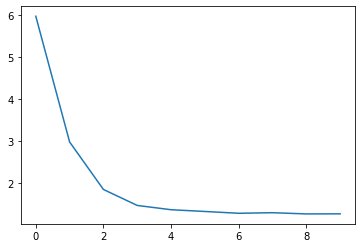

In [31]:
import matplotlib.pyplot as plt 

%matplotlib inline
plt.plot((models_dict[256,100,24]['epoch_loss']))

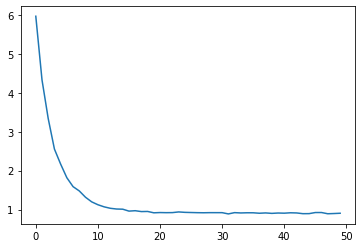

In [ ]:
import matplotlib.pyplot as plt 

%matplotlib inline
plt.plot(epoch_loss)

In [32]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(i,j):
    cos_sim = dot(genre_embeddings[i], \
                  genre_embeddings[j])/(norm(genre_embeddings[i])*norm(genre_embeddings[j]))

    return cos_sim

In [33]:
batch_dict = {}
batch_dict['genre']=torch.Tensor(list(genres_to_idx.values())).long()
batch_dict['user_id'] = torch.Tensor(full_table['user_id'].unique()).long()
batch_dict['item_id'] = torch.Tensor(full_table['movie_id'].unique()).long()



In [34]:
genre_embeddings = models_dict[256,100,24]['trained_model']("genre",batch=batch_dict['genre']).cpu().detach().numpy()
movie_embeddings = models_dict[256,100,24]['trained_model']("item_id",batch=batch_dict['item_id']).cpu().detach().numpy()
user_embeddings = models_dict[256,100,24]['trained_model']("user_id",batch=batch_dict['user_id']).cpu().detach().numpy()



In [35]:
import numpy as np
cos_matrix = np.zeros([len(genre_embeddings)]*2)
for i in range(len(genre_embeddings)):
    for j in range(len(genre_embeddings)):
        
        cos_matrix[i,j] = cosine_sim(i,j)

In [36]:
import pandas as pd 

pd.DataFrame(cos_matrix, columns=genres, index=genres)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Action,1.000000,0.044433,-0.181591,0.287410,0.728483,0.417385,-0.410150,0.683639,-0.067330,-0.504948,0.473774,-0.135429,-0.030783,0.099773,0.104578,0.708024,0.237193,-0.040155
Adventure,0.044433,1.000000,-0.128916,-0.064030,0.066832,-0.076399,-0.183113,0.071745,-0.020376,-0.166703,-0.019350,-0.196614,0.991077,-0.009591,-0.007050,0.010214,-0.070668,-0.017461
Animation,-0.181591,-0.128916,1.000000,0.715502,-0.272120,0.161899,0.626881,-0.314059,-0.153200,0.582625,-0.025414,0.743403,-0.118659,-0.131980,-0.220582,-0.149938,0.279997,-0.103782
Children's,0.287410,-0.064030,0.715502,1.000000,0.247295,0.295086,0.250093,0.200844,-0.154876,0.122944,0.252973,0.551979,-0.110388,0.006945,-0.124599,0.253823,0.332059,-0.104181
Comedy,0.728483,0.066832,-0.272120,0.247295,1.000000,0.306600,-0.529434,0.813107,-0.041041,-0.617625,0.478657,-0.181133,0.009300,0.125795,0.122090,0.676720,0.111046,-0.008605
Crime,0.417385,-0.076399,0.161899,0.295086,0.306600,1.000000,0.115330,0.308604,-0.183228,0.165818,0.314889,0.277259,-0.087766,0.040568,-0.119625,0.408259,0.319536,-0.096529
Documentary,-0.410150,-0.183113,0.626881,0.250093,-0.529434,0.115330,1.000000,-0.521655,-0.143204,0.784666,-0.138598,0.616286,-0.126197,-0.117966,-0.271658,-0.388122,0.333590,-0.086691
Drama,0.683639,0.071745,-0.314059,0.200844,0.813107,0.308604,-0.521655,1.000000,-0.026957,-0.598435,0.454701,-0.204250,0.015669,0.128191,0.127272,0.660632,0.116365,0.002379
Fantasy,-0.067330,-0.020376,-0.153200,-0.154876,-0.041041,-0.183228,-0.143204,-0.026957,1.000000,-0.106079,-0.093340,-0.144654,-0.013549,-0.023533,0.971615,-0.083149,-0.135063,-0.011041
Film-Noir,-0.504948,-0.166703,0.582625,0.122944,-0.617625,0.165818,0.784666,-0.598435,-0.106079,1.000000,-0.207258,0.519778,-0.101820,-0.128803,-0.234599,-0.367036,0.275829,-0.094216


In [37]:
from umap import UMAP

reduced_user = UMAP(n_jobs=-1, n_neighbors=5,n_components=2).fit_transform(user_embeddings)
reduced_movie = UMAP(n_jobs=-1, n_neighbors=5,n_components=2).fit_transform(movie_embeddings)
reduced_genre = UMAP(n_jobs=-1, n_neighbors=5,n_components=2).fit_transform(genre_embeddings)




/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


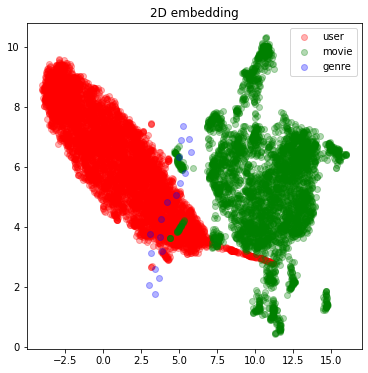

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reduced_user[:,0],reduced_user[:,1],color='red',alpha=0.3,label="user")
plt.scatter(reduced_movie[:,0],reduced_movie[:,1],color='green',alpha=0.3, label='movie')
plt.scatter(reduced_genre[:,0],reduced_genre[:,1],color="blue",alpha=0.3,label="genre")


plt.legend()

plt.title("2D embedding")
plt.show()

In [64]:
from sklearn.neighbors import kneighbors_graph

graph = kneighbors_graph(movie_embeddings,3, include_self=True, mode='connectivity')

In [52]:
def top_3_rec(elem,graph):
    
    similar_items = graph[elem].nonzero()[1].tolist()
    return items[items.movie_id.isin(similar_items)]

In [61]:
top_3_rec(124,graph)

,movie_id,movie_title,genres,genre_list,genre_list_idx
63,64,Two if by Sea (1996),Comedy|Romance,"[Comedy, Romance]","[4, 13]"
90,92,Mary Reilly (1996),Drama|Thriller,"[Drama, Thriller]","[7, 15]"
122,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,[Drama],[7]
